In [1]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
import random
import math
import numpy as np

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, find_average
#from helper_functions_tsp import find_total_distance
#from helper_functions_tsp import find_problem_size, convert_bit_string_to_cycle
#from helper_functions_tsp import convert_bit_string_to_matrix, calculate_penalty_sums, calculate_distance

#from qiskit_machine_learning.neural_networks import EstimatorQNN

#from qiskit_algorithms.utils import algorithm_globals

#algorithm_globals.random_seed = 42

In [2]:
LOCATIONS = 4                 #number of locations to be visited
VERBOSE = False               #controls how much is printed
#RELEVANT_VALUES = 50         #controls how many of the items to average over as a percentage
                              #eg 100 = all 
                              #30 = top 30%
#LEARNING_RATE = 1e-2         #learning rate
#UPDATES = 100                #updates, or iterations
#PRINT_FREQUENCY = 20         #how often results are printed out
#SPSA = False                 #SPSA stochastic gradient descent used
#DEBUG = False                #Extra data printed out

In [3]:
bin_len, qubits = find_problem_size(LOCATIONS)

In [4]:
data_sources = {  4 : {'file' : 'data/four_d.txt'},
                  5 : {'file' : 'data/five_d.txt'},
                 15 : {'file' : 'data/p01_d.txt'},
                 17 : {'file' : 'data/gr17_d.txt'},
                 26 : {'file' : 'data/fri26_d.txt'},
                 42 : {'file' : 'data/dantzig42_d.txt'},
                 48 : {'file' : 'data/att48_d.txt'}
                }

In [5]:
# may not be needed.
#from qiskit_algorithms.optimizers import COBYLA

In [6]:
filename = read_file_name(LOCATIONS, data_sources)
print(f'Data will be read from filename {filename}')

Data will be read from filename data/four_d.txt


In [7]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

In [8]:
def initialise_parameters(qubits):
    #initialise parameter text
    params1 = []
    for i in range(qubits):
        text1 = "weight" + str(2*i)
        text2 = "weight" + str(2*i +1 )
        params1.append(Parameter(text1 ))
        params1.append(Parameter(text2 ))
    #initialise parameters with random weights    
    for i in range(qubits * 2):
        params1[i] = random.random() * 2 * math.pi
        if VERBOSE:
            print(params1[i])
    return params1

In [9]:
def vqc_circuit(qubits, params1):
    #set up a variational quantum circuit
    qc = QuantumCircuit(qubits)
    for i in range(qubits):
        qc.h(i)
        qc.ry(params1[2*i], i)
        qc.rx(params1[2*i+1], i)
    for i in range(qubits-1):
            qc.cx(i,i+1)
    qc.measure_all()
    return qc

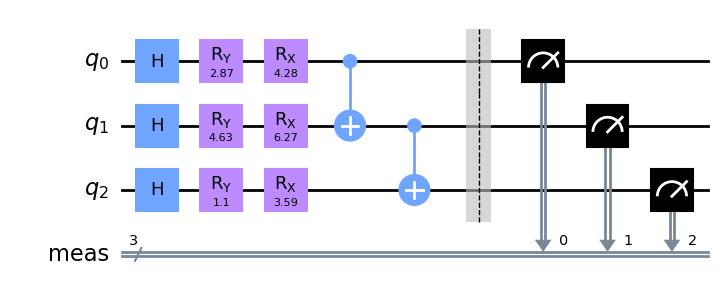

In [10]:
from qiskit_aer.primitives import SamplerV2

sampler = SamplerV2()
SHOTS = 1000

params1 = initialise_parameters(qubits)

qc = vqc_circuit(qubits, params1)

#draw the first circuit
qc.draw("mpl", style="clifford")

In [11]:
job = sampler.run([qc], shots = SHOTS)
results = job.result()
counts = results[0].data.meas.get_counts()
if VERBOSE:
    print(counts)

In [12]:
#from qiskit.circuit.library import TwoLocal
#ansatz = TwoLocal(QUBITS, ["ry", "rz"], "cz", reps=3)

In [13]:
#ansatz.draw("mpl", style="clifford")

In [14]:
print(counts)

{'000': 486, '111': 410, '100': 53, '011': 49, '001': 1, '110': 1}


In [16]:
cost = find_average(counts, LOCATIONS, distance_array, SHOTS, VERBOSE)

In [17]:
print(cost)

21.212
